# 剪枝

建议先阅读：
- [决策树概率与基本流程](./summary.ipynb)。
- [ID3、C4.5、CART决策树算法](./ID3-C45-CART.ipynb)。

## Introduce

剪枝（pruning）是决策树学习算法对付“过拟合”的主要手段。主动去掉一些分支，防止决策树把训练集自身的特点当作所有数据都具有的一般性质。

决策树剪枝的基本策略有“预剪枝”（prepruning）和“后剪枝”（postpruning）：
- 预剪枝是指在决策树生成过程中，对每个结点在划分前先进行估计，若当前结点的划分不能带来决策树泛化性能提升，则停止划分并将当前结点标记为叶结点。
- 后剪枝是先从训练集生成一颗完整的决策树，然后自底向上地对非叶结点进行考察，若将改结点对应的子树替换为叶结点能带来决策树泛化性能提升，则将该子树替换为叶结点。

优缺点：

- 预剪枝训练时间短，但有欠拟合的风险。
- 后剪枝泛化性能往往优于预剪枝，但训练时间开销比未剪枝决策树和预剪枝决策树都要大得多。

## Demo

通过例子对剪枝有一个直观的认识。以如下一份来自周志华老师《机器学习》的西瓜数据集为例，分别演示预剪枝、后剪枝的过程。

In [1]:
import pandas as pd
from collections import OrderedDict

data_dict = OrderedDict( (
        ('色泽', ['青绿', '乌黑', '乌黑', '青绿', '浅白', '青绿', '乌黑', '乌黑', '乌黑', '青绿', '浅白', '浅白', '青绿', '浅白', '乌黑', '浅白', '青绿']),
        ('根蒂', ['蜷缩', '蜷缩', '蜷缩', '蜷缩', '蜷缩', '稍蜷', '稍蜷', '稍蜷', '稍蜷', '硬挺', '硬挺', '蜷缩', '稍蜷', '稍蜷', '稍蜷', '蜷缩', '蜷缩']),
        ('敲声', ['浊响', '沉闷', '浊响', '沉闷', '浊响', '浊响', '浊响', '浊响', '沉闷', '清脆', '清脆', '浊响', '浊响', '沉闷', '浊响', '浊响', '沉闷']),
        ('纹理', ['清晰', '清晰', '清晰', '清晰', '清晰', '清晰', '稍糊', '清晰', '稍糊', '清晰', '模糊', '模糊', '稍糊', '稍糊', '清晰', '模糊', '稍糊']),
        ('脐部', ['凹陷', '凹陷', '凹陷', '凹陷', '凹陷', '稍凹', '稍凹', '稍凹', '稍凹', '平坦', '平坦', '平坦', '凹陷', '凹陷', '稍凹', '平坦', '稍凹']),
        ('触感', ['硬滑', '硬滑', '硬滑', '硬滑', '硬滑', '软粘', '软粘', '硬滑', '硬滑', '软粘', '硬滑', '软粘', '硬滑', '硬滑', '软粘', '硬滑', '硬滑']),
        ('好瓜', ['是', '是', '是', '是', '是', '是', '是', '是', '否', '否', '否', '否', '否', '否', '否', '否', '否'])
    ) )

data = pd.DataFrame.from_dict(data_dict)
data

,色泽,根蒂,敲声,纹理,脐部,触感,好瓜
0,青绿,蜷缩,浊响,清晰,凹陷,硬滑,是
1,乌黑,蜷缩,沉闷,清晰,凹陷,硬滑,是
2,乌黑,蜷缩,浊响,清晰,凹陷,硬滑,是
3,青绿,蜷缩,沉闷,清晰,凹陷,硬滑,是
4,浅白,蜷缩,浊响,清晰,凹陷,硬滑,是
5,青绿,稍蜷,浊响,清晰,稍凹,软粘,是
6,乌黑,稍蜷,浊响,稍糊,稍凹,软粘,是
7,乌黑,稍蜷,浊响,清晰,稍凹,硬滑,是
8,乌黑,稍蜷,沉闷,稍糊,稍凹,硬滑,否
9,青绿,硬挺,清脆,清晰,平坦,软粘,否


将数据划分为训练集与测试集：

In [2]:
train = data.iloc[[0,1,2,5,6,9,13,14,15,16], :]
test = data.iloc[[3,4,7,8,10,11,12], :]

print(train, end="\r\n\r\n")
print(test)

    色泽  根蒂  敲声  纹理  脐部  触感 好瓜
0   青绿  蜷缩  浊响  清晰  凹陷  硬滑  是
1   乌黑  蜷缩  沉闷  清晰  凹陷  硬滑  是
2   乌黑  蜷缩  浊响  清晰  凹陷  硬滑  是
5   青绿  稍蜷  浊响  清晰  稍凹  软粘  是
6   乌黑  稍蜷  浊响  稍糊  稍凹  软粘  是
9   青绿  硬挺  清脆  清晰  平坦  软粘  否
13  浅白  稍蜷  沉闷  稍糊  凹陷  硬滑  否
14  乌黑  稍蜷  浊响  清晰  稍凹  软粘  否
15  浅白  蜷缩  浊响  模糊  平坦  硬滑  否
16  青绿  蜷缩  沉闷  稍糊  稍凹  硬滑  否

    色泽  根蒂  敲声  纹理  脐部  触感 好瓜
3   青绿  蜷缩  沉闷  清晰  凹陷  硬滑  是
4   浅白  蜷缩  浊响  清晰  凹陷  硬滑  是
7   乌黑  稍蜷  浊响  清晰  稍凹  硬滑  是
8   乌黑  稍蜷  沉闷  稍糊  稍凹  硬滑  否
10  浅白  硬挺  清脆  模糊  平坦  硬滑  否
11  浅白  蜷缩  浊响  模糊  平坦  软粘  否
12  青绿  稍蜷  浊响  稍糊  凹陷  硬滑  否


将数据集按特征、标签拆分开。

In [6]:
X_train = train.drop('好瓜', axis=1)
y_train = pd.DataFrame(train['好瓜'], columns=['好瓜'])
print(X_train.shape, y_train.shape)

X_test = test.drop('好瓜', axis=1)
y_test = pd.DataFrame(test['好瓜'], columns=['好瓜'])
print(X_test.shape, y_test.shape)

(10, 6) (10, 1)
(7, 6) (7, 1)


引入决策树绘制函数，代码来自于《机器学习实战》

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# 定义文本框和箭头格式
decisionNode = dict(boxstyle='sawtooth', fc='0.8')
leafNode = dict(boxstyle='round4', fc='0.8') #叶结点
arrow_args = dict(arrowstyle='<-') #箭头类型

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    """ 绘制一个结点，并有箭头指向该结点
    Args:
        nodeTxt：结点文字
        centerPt：结点位置
        parentPt：箭头起始位置
        nodeType：结点类型，decisionNode或leafNode
    """
    # 全局变量createPlot.ax1定义了绘图区
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va='center', ha='center', bbox=nodeType, arrowprops=arrow_args)

def getNumLeafs(myTree):
    """ 获取叶结点的数目
    """
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs
            
def getTreeDepth(myTree):
    """ 获取树的层数
    """
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth

def plotMidText(cntrPt, parentPt, txtString):
    """ 在父子结点间填充文本信息
    Args：
        cntrPt：结点位置
        parentPt：箭头起始位置
        txtString：文字
    """
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)
    
def plotTree(myTree, parentPt, nodeTxt):
    """ 绘制树
    """
    numLeafs = getNumLeafs(myTree) #当前树宽
    depth = getTreeDepth(myTree) # 当前树高
    firstStr = list(myTree.keys())[0] #根结点的属性
    
    # x的偏移量要保证在 0.5/plotTree.totalW 到 (plotTree.totalW-0.5) / plotTree.totalW 的范围内均匀分布
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode) #绘制根结点
    secondDict = myTree[firstStr] # 根结点的子树
    
    plotTree.yOff = plotTree.yOff - 1.0 / plotTree.totalD # 绘制下一层的时候，y减去一层的高度
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            # 子树是一棵树，递归绘制
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            # 子树不是树，那么是一个叶子结点
            plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
            
    plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD # 回到当前层的位置
    

def createPlot(inTree):
    """ 绘制入口
    整个绘图在x=(0, 1.0)，y=(0, 1.0)的范围内完成。左下角是点(0, 0)，右上角是点(1.0, 1.0)。
    所以，根结点的中心在(0.5, 1.0)处
    """
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW # 按照叶子结点数目将x轴划分为若干部分
    plotTree.yOff = 1.0 # y的偏移量以1为基准
    plotTree(inTree, (0.5, 1.0), '')
    plt.show()

不剪枝的情况下，决策树应该如下。我得到的树与周志华老师的有细微出入，但我这里暂时没有发现问题。周老师的树应该是对属性值缺失的属性作了补全处理。

{'脐部': {'稍凹': {'根蒂': {'蜷缩': '否', '稍蜷': {'色泽': {'青绿': '是', '乌黑': {'纹理': {'清晰': '否', '稍糊': '是'}}}}}}, '平坦': '否', '凹陷': {'色泽': {'青绿': '是', '浅白': '否', '乌黑': '是'}}}}


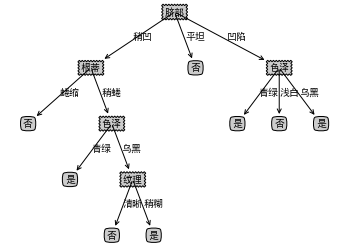

In [14]:
from math import log

def information_entropy(labels):
    """ 计算信息熵
    Args:
        labels：数据集的标签
    Return:
        信息熵
    """
    list_p = []
    for i in set(labels.iloc[:, 0]):
        list_p.append(len(labels[labels.iloc[:, 0] == i]) / len(labels))
    
    e = 0.0
    for p in list_p:
        e -= p * log(p, 2) 
    return e
    
def condition_entropy(d, l, a):
    """ 计算条件熵
    Args:
        d: 数据集，pandas.DataFrame格式，不包含标签
        l: 数据集对应的标签
        a: 属性名，即数据集某一列的名称
    Return:
        条件熵
    """
    ce = 0
    for i in set(d[a]):
        ce += information_entropy(l.loc[d[a] == i]) * len(d[d[a] == i]) / len(d)
    return ce

def information_gain(d, l,  a):
    """ 计算信息增益
    Args:
        d: 数据集，pandas.DataFrame格式，不包含标签
        l: 数据集对应的标签
        a: 属性名，即数据集某一列的名称
    Return:
        信息增益
    """
    return information_entropy(l) - condition_entropy(d, l, a)

def max_gain(d, l):
    """ 选择信息增益最大的属性
    Args:
        d: 数据集，pandas.DataFrame格式，不包含标签
        l: 数据集对应的标签
    Return:
        信息增益最大的属性
    """
    max_gain = -0.1
    max_a = ''
    for a in list(d.columns):
        g = information_gain(d, l, a)
        if max_gain < g:
            max_gain = g; max_a = a
        elif max_gain == g: # 与周志华老师的特征选择保持一致
            if a == '脐部':
                max_a = a
    return max_a

def create_tree(d, l):
    """ 创建决策树
    Args:
        d: 数据集，pandas.DataFrame格式，不包含标签
        l: 数据集对应的标签
    Return:
        字典格式的决策树
    """
    # 类别完全相同时停止划分
    if len(l.iloc[:, 0].value_counts()) == 1:
        return l.iloc[:, 0].iloc[0]
    # 没有特征可以用了，选择数量多的标签
    if len(d.columns) == 0:
        return l.value_counts().idxmax()
            
    max_a = max_gain(d, l) # 选择特征
    
    myTree = {max_a: {}}
    for aa in set(d[max_a]):
        myTree[max_a][aa] = create_tree(d.loc[d[max_a]==aa, :].drop(max_a, axis=1), l.loc[d[max_a]==aa, :])
    
    return myTree

t = create_tree(X_train, y_train)
print(t)

# 中文乱码时，需要设置字体。Windows系统适用
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
createPlot(t)

该树对训练集的表现并不理想：

In [24]:
def predict(_tree, row):
    """ 对一个样本进行预测
    Args:
        _tree: 字典类型的决策树
        row: 一个样本
    Return:
        该样本的预测标签
    """
    if type(_tree).__name__ == 'dict':
        k = list(_tree.keys())[0]
        return predict(_tree[k][row[k]], row)
    else:
        return _tree

def accuracy(_tree, _X_test, _y_test):
    """ 计算测试集的精度
    Args:
        _tree: 字典类型的决策树
        _X_test: 测试集的属性值
        _y_test: 测试集的真实标签
    Return:
        决策树在测试集上的精度
    """
    _true = _false = 0
    for index, row in _X_test.iterrows():
        if _y_test.loc[index, :][0] == predict(t, row):
            _true += 1
        else:
            _false += 1
            
    return _true / (_true + _false)
    
accuracy(t, X_test, y_test)

0.42857142857142855

### 预剪枝



In [25]:
def max_gain(d):
    max_gain = -0.1
    max_a = ''
    for a in list(d.columns):
        if a == '好瓜':
            continue
        
        g = information_gain(d, a)
        if max_gain < g:
            max_gain = g; max_a = a
        elif max_gain == g: # 为了与周志华老师的树保持一致
            if a == '脐部':
                max_a = a
    return max_a

def judge(t1, t2):
    pass

def attr_judge(d, attr):
    if len(d.loc[:, '好瓜'].value_counts()) == 1:
        return {'': '坏瓜'} if d.loc[:, '好瓜'].iloc[0] == '否' else {'': '好瓜'}
    
    if len(set(d[attr])) == 1:
        return '坏瓜' if d.loc[:, '好瓜'].value_counts().idxmax() == '否' else '好瓜'
    
    return set(d[attr])

def create_tree2(d, ptree, attr):
    aj = attr_judge(d, attr)
    if type(aj).__name__ != 'set':
        ptree[attr] = aj
    else:
        for aa in aj:
            if len(d.loc[d[attr]==aa, '好瓜'].value_counts()) == 1:
                ptree[attr][aa] = '坏瓜' if d.loc[d[attr]==aa, '好瓜'].iloc[0] == '否' else '好瓜'
            else:
                max_a = max_gain(d.loc[d[attr]!=aa, :].drop(attr, axis=1)) # 选择特征
                ptree[attr][aa] = {max_a: {}}
#                 ptree[attr][aa] = create_tree2(d.loc[d[attr]!=aa, :].drop(attr, axis=1), ptree[attr][aa], max_a)
    
    if type(aj).__name__ == 'set':
        for aa in aj:
            if type(ptree[attr][aa]).__name__ == 'dict':
                ptree[attr][aa] = create_tree2(d.loc[d[attr]!=aa, :].drop(attr, axis=1), ptree[attr][aa], list(ptree[attr][aa].keys())[0])
    
    return ptree

attr = max_gain(train) # 选择特征
inTree = {attr: {}}
tttttt = create_tree2(train, inTree, attr)
print(tttttt)
createPlot(tttttt)

TypeError: information_gain() missing 1 required positional argument: 'a'